In [10]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

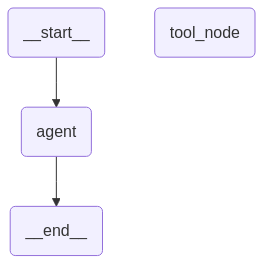

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [12]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='8784c30f-0337-4c4d-b374-8207873808c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zm83', 'function': {'arguments': '{"query": "Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.026666667, 'prompt_time': 0.018380821, 'queue_time': 0.19077507600000002, 'total_time': 0.045047488}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e2719fd9-9ede-4f71-b10d-61142655069c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather'}, 'id': 'call_zm83', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(content='[{"title

Case 1: Shared Schema (Direct Embedding)

In [13]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='ee5ecf09-ef9c-4b77-99dc-8787a317f429'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_70xm', 'function': {'arguments': '{"query": "Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.028, 'prompt_time': 0.011828783, 'queue_time': 0.11674665600000002, 'total_time': 0.039828783}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-92142b20-376f-459d-bf5a-7acfaeeae96c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'call_70xm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}),
  ToolMessage(content='[{

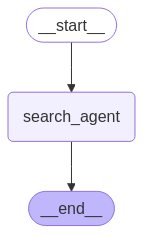

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [19]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState):
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
print(result)

{'query': 'How is the weather in Chennai?', 'response': 'The weather in Chennai is expected to be partly cloudy with a maximum temperature of 34°C and a minimum of 29°C.'}
